# Implementing Deep Neural Networks for YouTube Recommendations in PyTorch

---



[Deep Neural Networks for YouTube Recommendations](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf), published in 2016 by Paul Covington, Jay Adams and Emre Sargin, has a great impact on the development of recommendation system. The system has two major components: candidate generation and ranking. 

In this tutorial, I implement the candidate generation system. As YouTube does not release its data, I use MovieLens data set to model it.

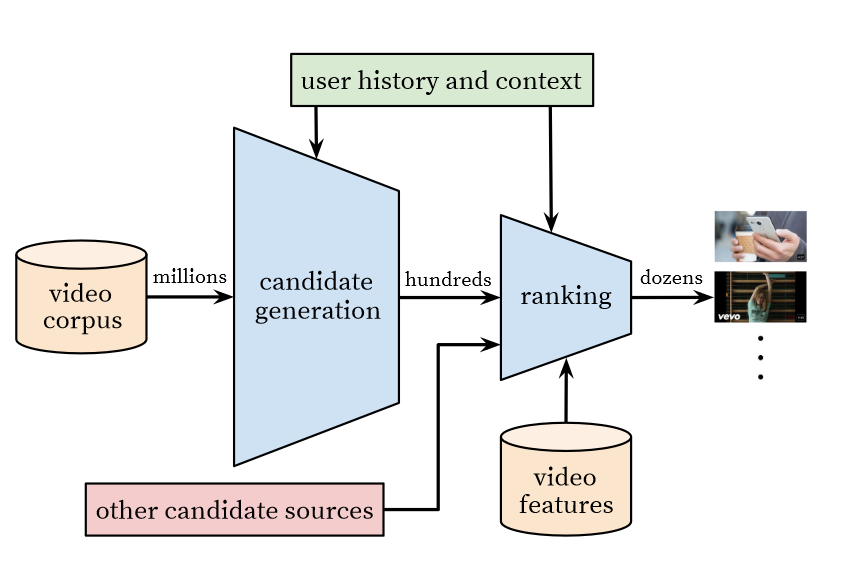

In [30]:
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from nltk.tokenize import word_tokenize
import torch.nn as nn
import torch.nn.functional as F

In [31]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Import data set.
Download the MovieLens data set from its official website. It contains three data sets: *Ratings*, *Users*, *Movies*.

In [32]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

In [33]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', engine='python', header = None, names  = ['user_id','movie_id','rating','timestamp'])
users = pd.read_csv('ml-1m/users.dat', sep = '::', engine='python', header = None, names  = ['user_id', 'gender', 'age', 'occupation', 'zip_code'])
movies = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python', header = None, names=['movie_id', 'title', 'genres'])

The data sets have 1 million ratings rated by 6,000 users on 3,800 movies between 2000-04-25 and 2003-02-28. Let's take a look at the data sets.

In [34]:
print('Ratings:')
print(ratings.head(2))

Ratings:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109


In [35]:
print('Users:')
print(users.head(2))

Users:
   user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072


In [36]:
print('Movies:')
print(movies.head(2))


Movies:
   movie_id             title                        genres
0         1  Toy Story (1995)   Animation|Children's|Comedy
1         2    Jumanji (1995)  Adventure|Children's|Fantasy


The candidate generation component is illustrated as below:
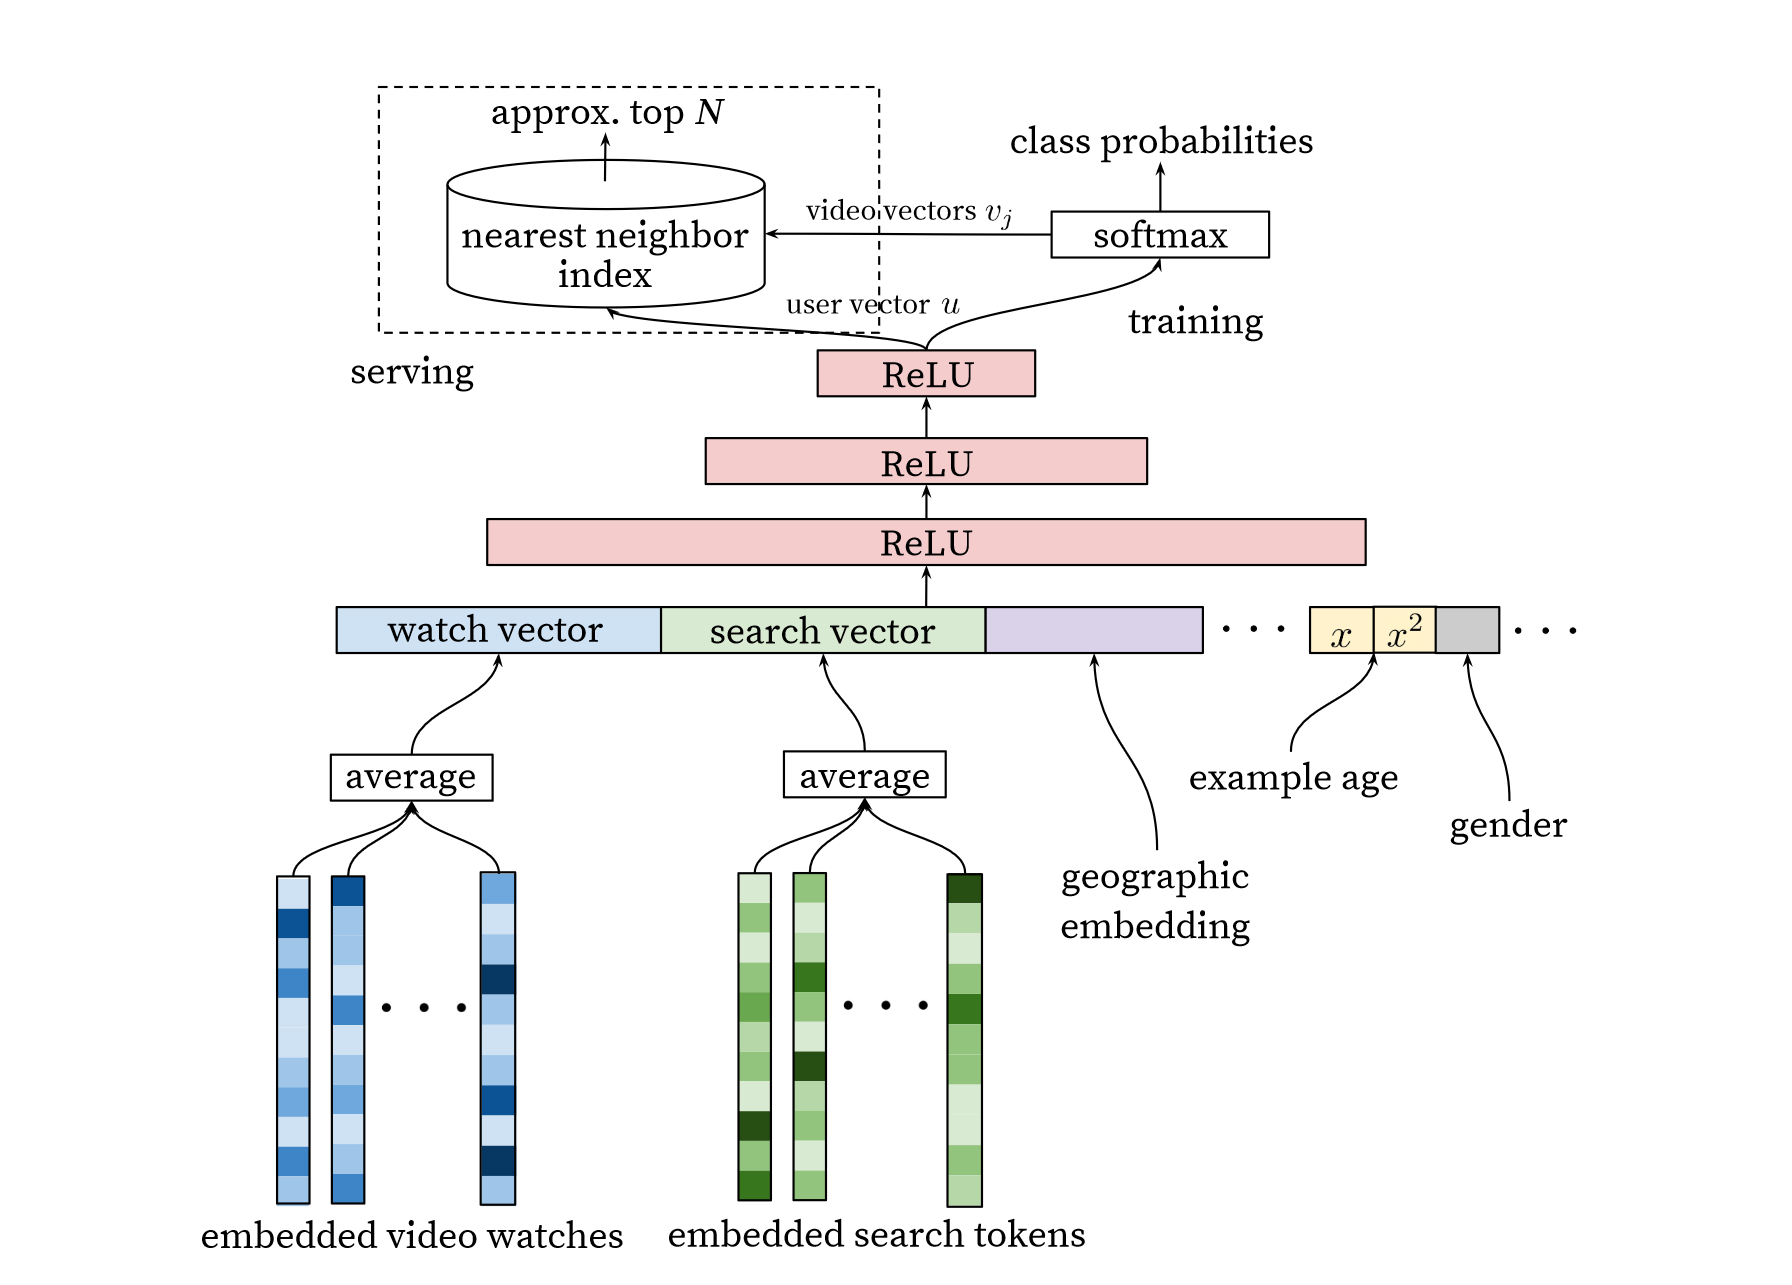



The YouTube paper uses video watches, search history, and user context (such as gender) to train the model. Note that Youtube does not use explicit rating because it is extremely sparse. Instead, it uses the implicit feedback of watches, where a user completing a video is a positive example. I model the input information of the NN model as follows:

*   Video watches: I use the rating pairs as evidences that the user has completed the video. The movies rated by a user in the *Ratings* data set are considered as the user's video watches. 

*   Search history: The title of a completed movie is taken as the search tokens for that user.

*   User context: the information provided in the *Users* data set, namely gender, age and occupation, are used as context variables. 

Example age is in fact an important feature in the YouTube model. Recommending  recently  uploaded content is extremely important for YouTube because users prefer fresh content. However, given that the rating time in the data set was between 2000-04-25 23:05:32 and 2003-02-28 17:49:50, which is a relatively short period, while the movies' production time varies across a long period. It is not sensible to model the example age using this data set.

# 2. Data preprocessing.

## 2.1 Data preprocessing for search tokens.

[GloVe](https://nlp.stanford.edu/projects/glove/) works better than many other pre-trained word embeddings in a wide range of subsequent NLP tasks. It encodes meaning components in vector differences. Furthermore, it was trained on Wikipedia which is about definitions and explanations of terms, while Google's Word2vec was trained on Google new corpus. The word embedding training model probably learns more from corpus explaining terms than news about who had committed a crime. So it makes sense that GloVe has better performance. 

I use the GloVe pre-trained word embeddings for the search tokens. Download the glove.6B.zip file [here](https://nlp.stanford.edu/data/glove.6B.zip). 

GloVe pre-trained embeddings come in different dimensions: 50, 100, 200, 300. The number of word embedding dimensions directly affects the number of NN input dimensions. As the number of training examples is not very big, I don't want a huge word embedding dimension. In addition, this is not a pure NLP task. A coarse word embedding is acceptable. Thus, I choose 50 dimensions for this task.  

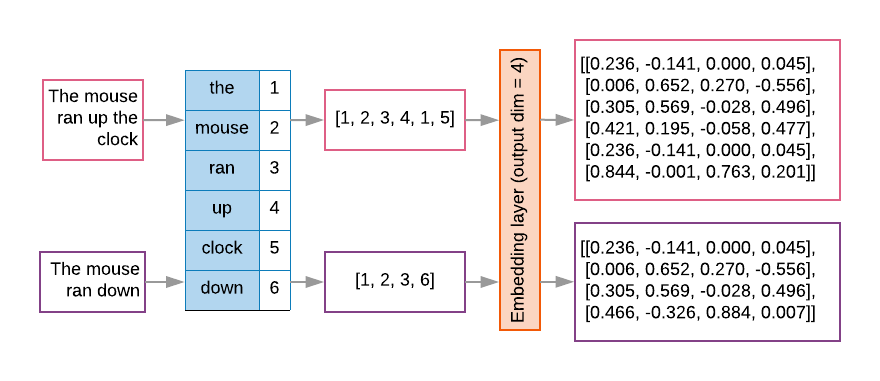
https://developers.google.com/machine-learning/guides/text-classification/images/EmbeddingLayer.png

The word embedding works as follows: 

First we create a vocabulary which includes all the words in the search history (movie titles), and assign an integer index for each word. Let's use the above chart to illustrate this process. For example, if the data set has only six words ("the", "mouse", "ran", "up", "clock", "down"), so the vocabulary only has six words, and we assign integers 1-6 as indices for each of them. 

Then we replace the tokens in the data set with their corresponding indices. For example, one search hisory A "the mouse ran up the" is converted to [1, 2, 3, 4, 1] (here I don't use "the mouse ran up the clock". I set the number of words in the sentence differ from the number of words in the vocabulary to avoid confusion). 

Next, we retrieve the pre-trained embedding vectors from GloVe for each word in the vocabulary and hold them in a embedding matrix. This matrix has a shape (number of words in the vocabulary, number of word embedding dimensions) (i.e. shape (6,4) in this example). 

The search hisory A [1, 2, 3, 4, 1] is converted to [1_vec, 2_vec, 3_vec, 4_vec, 1_vec] where i_vec is the pre-trained word embedding vector for token i. Now the search history is converted into a matrix of shape (number of words in search history A, number of word embedding dimensions) (i.e. shape (5,4) in this example).

At last, we take the average across the words to get a vector whose length is the number of word embedding dimensions (i.e. 4 in this example) as the representation of search hisory A "the mouse ran up the" and feed it into the neural network. By the way, there could be other concatenation methods apart from averaging, such as component-wise max, sum, etc. But for most tasks, averaging works best, the intuition is we don't want extreme words dominate the value of search history.

In this way, no matter how long the search history is (for instance, the search history may be like ["Allan Quartermain and the Lost City of Gold", "Amityville 1992: It's About Time", ...], probably has hundreds of search records and each search record has several tokens), we can reduce it to a fixed number of word embedding dimensions (i.e. 50 in this tutorial). Note that only unigram is considered and the Bag of Words assumption is used here.

Let's implement this idea. First, tokenize the movie titles into the "search" column.

In [37]:
def movies_prep(dataset = movies):
  ''' Prepare the movies data set.
  '''

  # the contents of movies.title column includes years. Extract only movie titles to that column.
  dataset['title'] = dataset.title.str.extract(r'(^[^\(]+)')
  # lowercase
  dataset['title'] = dataset['title'].apply(lambda x: x.lower())
  # tokenize
  dataset['search'] = dataset['title'].apply(lambda x: word_tokenize(x))

  return dataset

movies = movies_prep(movies)
print(movies.head(2))

   movie_id       title                        genres        search
0         1  toy story    Animation|Children's|Comedy  [toy, story]
1         2    jumanji   Adventure|Children's|Fantasy     [jumanji]


Second, create a dictionary: *word_to_index* which maps a word in the vocabulary (all the words appeared in movie titles) to an index. Create another dictionary *index_to_word* holds the reverse. Replace the words with their indices in the "search" column.

In [38]:
def mapping(row, word_to_index):
    '''Sub-function used in map_to_id_list(). '''
    
    i = 0
    while i < len(row):
        row[i] = word_to_index[row[i]]
        i += 1
        
    return row
        

def word_map_to_id(dataset, column):
    ''' Convert a dataset.column whose cell is like ['a', 'story'] to [1, 2], where 1, 2 are the index of 'a', 'story' in 
    the constructed dictionary.
    The indices are integers, starting from 1 to the vocabulary size (no 0).
    
    Arguments:
    -- dataset. Name of the dataset.
    -- column name. In string form, e.g. 'user_id'.
    
    Return:
    -- A dictionary mapping {word: index}. 
    -- A dictionary mapping {index: word}.
    -- A modified dataset with the argument column is replaced by the corresponding mapped column.'''
    
    voc_lst = []
    i = 0
    col_index = dataset.columns.get_loc(column)
    while i < dataset.shape[0]:
        voc_lst.extend(dataset.iloc[i, col_index])
        i += 1
        
    voc_set = set(voc_lst)
    word_to_index = {x: i+1 for i, x in enumerate(voc_set)}
    word_to_index['$PAD$'] = 0
    index_to_word = {v: k for k, v in word_to_index.items()}
    
    dataset[column] = dataset[column].apply(lambda x: mapping(x, word_to_index))
    
    return word_to_index, index_to_word, dataset


word_to_index, index_to_word, movies = word_map_to_id(movies, 'search') 

print(movies.head(2))

   movie_id       title                        genres        search
0         1  toy story    Animation|Children's|Comedy  [3881, 1487]
1         2    jumanji   Adventure|Children's|Fantasy        [3159]


In [39]:
print(len(index_to_word))

4054


The index_to_word dictionary has 4,054 elements. Index 0 is for padding words and token index start from 1. It is like:


> {0: '$PAD', 1: 'turbo', 2: 'hear', 3: 'robin', ...}

The word_to_index dictionary, the reverse of index_to_word is like:


> {'PAD': 0, 'turbo': 1, 'hear': 2, 'robin': 3, ...}







## 2.2 Other data preprocessing.
Pre-processing *Ratings* data set and merge all three data sets. Apply One Hot 
Encoding to the "gender" and "occupation" columns, and apply standardization (scale to zero mean unit variance) to the "age" column.

Similar to the words in the search history, userID is mapped to index and the index starts from 0. *userID_to_index* and *index_to_userID* hold the mappings between userID and indices. *Index_to_userID* is like:


> {0: 1, 1: 2, 2: 12, 3: 15, ...}

MovieID is also mapped to index and the index starts from 1 (0 is reserved for padding). *movieID_to_index* and *index_to_movieID* hold the mappings between movieID and indices. *Index_to_movieID* is like:


> {0: '$PAD', 1: 1193, 2: 661, 3: 914, ...}

In [40]:
def user_map_to_id(dataset, column):
  ''' Map distinct values of a dataset.column to consecutive integer ids (From 1, ... to number of distinct values).
  Value 0 for padding.
  
  Arguments:
  -- dataset. Name of the dataset.
  -- column name. In string form, e.g. 'user_id'.
  
  Return:
  -- A dictionary mapping {value: id}. Padding value id is 0.
  -- A dictionary mapping {id: value}. id = 0 for padding value.
  -- A modified dataset with the argument column is replaced by the corresponding mapped column.'''
  
  user_ids = dataset[column].unique().tolist()
  value_to_id = {x: i for i, x in enumerate(user_ids)}
  id_to_value = {v: k for k, v in value_to_id.items()}   
  dataset[column] = dataset[column].map(value_to_id)
  
  return value_to_id, id_to_value, dataset


def movie_map_to_id(dataset, column):
  ''' Map distinct values of a dataset.column to consecutive integer ids (From 1, ... to number of distinct values).
  Value 0 for padding.
  
  Arguments:
  -- dataset. Name of the dataset.
  -- column name. In string form, e.g. 'user_id'.
  
  Return:
  -- A dictionary mapping {value: id}. Padding value id is 0.
  -- A dictionary mapping {id: value}. id = 0 for padding value.
  -- A modified dataset with the argument column is replaced by the corresponding mapped column.'''
  
  user_ids = dataset[column].unique().tolist()
  value_to_id = {x: i+1 for i, x in enumerate(user_ids)}
  value_to_id['$PAD$'] = 0
  id_to_value = {v: k for k, v in value_to_id.items()}   
  dataset[column] = dataset[column].map(value_to_id)
  
  return value_to_id, id_to_value, dataset


def one_hot_encoding(dataset, attr_lst):
  ''' Perform One Hot Encoding on an attribute of a dataset.
  Arguments:
      -- dataset: the data set.
      -- attr_lst: the list of attribute names, in string form. E.g. ['a', 'b']
      
  Output:
      return the dataset with added encoded attributes. And the original attribute is dropped'''
      
  ohc = OneHotEncoder()
  for attr in attr_lst:
      ohe = ohc.fit_transform(dataset[attr].values.reshape(-1,1)).toarray()
      dfOneHot = pd.DataFrame(ohe,columns = [attr + '_' + str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])
      dataset = dataset.join(dfOneHot)
      dataset.drop([attr], axis = 1,inplace=True)
  
  return dataset


def get_groupby_dataset(ratings, users, movies):
  '''
  Get a merged data set where the record of each user is one row.
  '''

  # convert ratings.timestamp from timestamp to datetime
  ratings['time'] = pd.to_datetime(ratings['timestamp'], unit='s')  

  # merge data sets
  merged = ratings.merge(users, on=['user_id']).merge(movies, on=['movie_id']) 

  # map distinct values to id, preparing for the upcoming embedding.
  userID_to_index, index_to_userID, merged = user_map_to_id(merged, 'user_id')
  movieID_to_index, index_to_movieID, merged = movie_map_to_id(merged, 'movie_id')

  # create a data set that groupby user_id. Sorted by watch time.
  grouped = merged.sort_values(by = 'time').groupby('user_id').agg({'user_id': 'mean','movie_id': lambda mID: list(mID), 
                              'search': lambda title: list(title), 'gender': 'first',
                              'age': 'mean', 'occupation': 'mean'})
  
  # Do One Hot Encoding for 'gender' and 'occupation'.
  grouped = one_hot_encoding(grouped, ['gender', 'occupation'])

  # Normalize 'age'
  scaler = StandardScaler()
  grouped['age'] = scaler.fit_transform(grouped['age'].values.reshape(-1,1))
  
  return grouped, userID_to_index, index_to_userID, movieID_to_index, index_to_movieID


grouped, userID_to_index, index_to_userID, movieID_to_index, index_to_movieID = get_groupby_dataset(ratings, users, movies)


print('Column names:', grouped.columns.values)

Column names: ['user_id' 'movie_id' 'search' 'age' 'gender_F' 'gender_M' 'occupation_0'
 'occupation_1' 'occupation_2' 'occupation_3' 'occupation_4'
 'occupation_5' 'occupation_6' 'occupation_7' 'occupation_8'
 'occupation_9' 'occupation_10' 'occupation_11' 'occupation_12'
 'occupation_13' 'occupation_14' 'occupation_15' 'occupation_16'
 'occupation_17' 'occupation_18' 'occupation_19' 'occupation_20']


Now we have a concatenated data set, each row of which is a user's record. It looks like this (only part of the columns are shown):

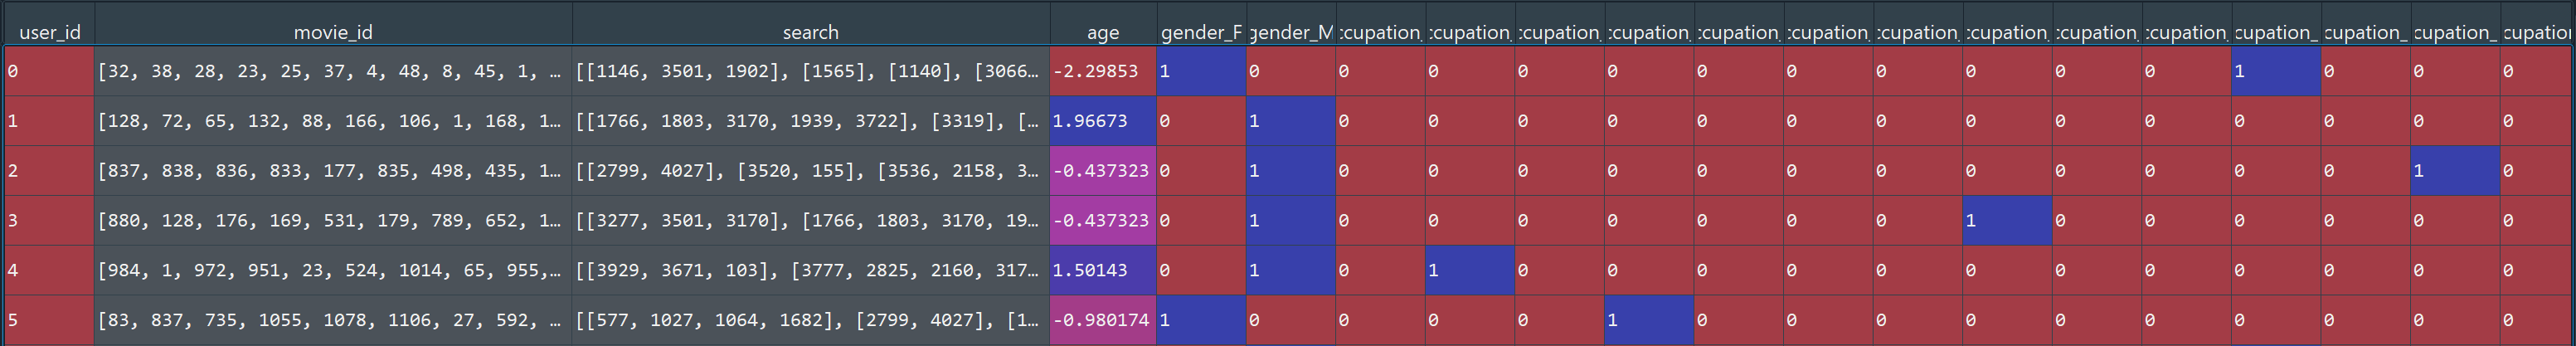

Next, prepare the training, validation and test data sets. The YouTube paper found much betterper formance predicting the user’s next watch, rather than predicting a randomly held-out watch (figure below). 

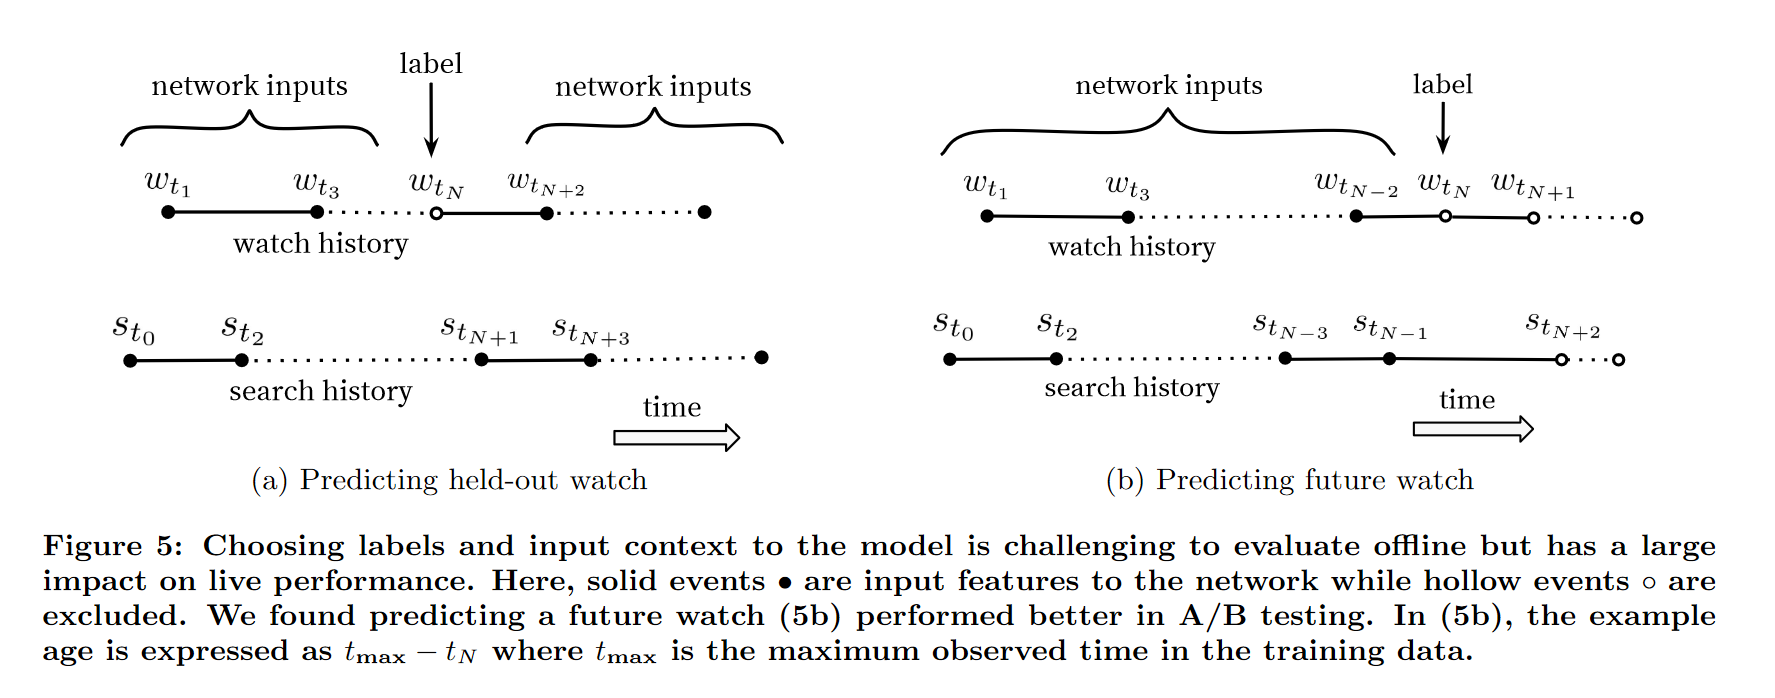

I sort the video watches according to the rating time, assuming that the rating time indicates the watch time. In the training set, I take the last-but-two movie watched as the label, and 50 movies prior to it as video watches for the user. The labels for the validation and test set are the last-but-one movie and the last movie watched, respectively.

Users have varied length of watch history. However, the paper finds that "Another key insight that improved live metrics was to generate a fixed number of training examples per user, eectively weighting our users equally in the loss function. This prevented a small cohort of highly active users from dominating the loss." Thus a cut-off value is set for the max length of video watches. If a user watched more than 50 movies (excluding the label movies), the movies watched before the last-but-fifty are truncated. If a user's video watches is less than 50, zeros are padded at the end of the video watches list (illustrated below, here I refer padding/truncate at the end while the figure refers padding/truncate in front). In this data set, there are 1,743 out of 6,040 users who watched less than 50 movies.

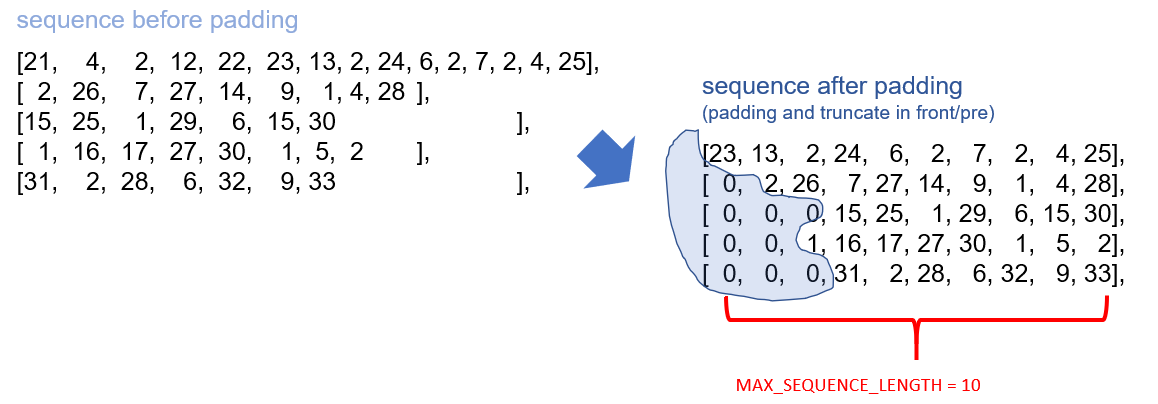
https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633

Similarly, a cut-off value for the max length of search tokens in each search record is also needed. For example, if the *max_token_len* is set to 8, so only the first eight tokens of each search are kept, and other tokens are discarded. The search queries are thus represented with an unordered bag of tokens which has fixed length.

In [41]:
def extract_list_to_multiple_columns(dataset, column, max_len, padding):
  '''
  Sub-function used in prepare_train_val_test().
  Extract a column comprised of  lists (one list in one cell) to multiple column, one column for 
  one element in the list. And drop the original column.

  Arguments:
  -- dataset. Name of the dataset.
  -- column. Column name, in string form.
  -- max_len. An integer. The length of the list in each cell is varied. Limit the length to the max_len. Discard the
  rest.
  -- padding. Define what to pad to the cells whose length is less than max_len.

  Returns:
  -- The resulted data set.
  '''

  i = 0
  for i in range(max_len):
      dataset[column +'_' + str(i)] = dataset[column].apply(lambda x: x[i] if i < len(x) else padding)
  dataset.drop(column, axis = 1, inplace = True)
      
  return dataset


def get_token_count(dataset):
    ''' 
    Sub-function used in prepare_train_val_test().
    Count the number of tokens in the search token history.
    Add one column named 'token_count' to the original dataset.'''
    
    df = dataset.filter(regex = 'search')
    dataset['token_count'] = (df!=0).astype(int).sum(axis=1)
    
    return dataset


def prepare_train_val_test(grouped, max_hist_len, max_token_len):
  '''
  Get train, validation and test sets.
    max_his_count           # the maximum number of watched videos. Tuneable.
    num_of_token     # tuneable. # The maximum length of title is 15. I limit the maximum length to 8. 
  '''
  # prepare the target labels.
  grouped['last_but_two_label'] = grouped.movie_id.apply(lambda x: x[-3])
  grouped['last_but_one_label'] = grouped.movie_id.apply(lambda x: x[-2])
  grouped['last_label'] = grouped.movie_id.apply(lambda x: x[-1])

  train = grouped.copy()
  test = grouped.copy()
  val = grouped.copy()

  # prepare the train set.
  train['movie_id'] = train['movie_id'].apply(lambda x: x[:-3] if (len(x) - 3) <= max_hist_len else x[-(max_hist_len+3):-3])
  train['search'] = train['search'].apply(lambda x: x[:-3] if (len(x) - 3) <= max_hist_len else x[-(max_hist_len+3):-3])
  train['hist_count'] = train['movie_id'].apply(lambda x: len(x))
  train.drop(['last_label', 'last_but_one_label'], axis = 1, inplace = True)
  train = train.rename(columns={'last_but_two_label': 'label', 'movie_id': 'video_watches'})

  # flatten the DataFrame
  train = extract_list_to_multiple_columns(train, 'video_watches', max_hist_len, padding = 0)   # padding = 0 because the movieID index starts from 1.
  train = extract_list_to_multiple_columns(train, 'search', max_hist_len, padding = [0])        # padding = 0 because the token index starts from 1.
  
  j = 0
  while j < max_hist_len:
      train = extract_list_to_multiple_columns(train, 'search_'+str(j), max_token_len, padding = 0)  # Discard tokens after max_token_len, and pad 0 to titles whose length is less than max_token_len.
      j += 1
      
  # create a column counting the number of search tokens
  train = get_token_count(train)   

  # prepare the validation set
  val = val[['user_id', 'last_but_one_label']]
  val = val.rename(columns={'last_but_one_label': 'label'})

  # prepare the test set.
  test = test[['user_id', 'last_label']]
  test = test.rename(columns={'last_label': 'label'})

  return train, val, test


train, val, test = prepare_train_val_test(grouped, max_hist_len = 50, max_token_len = 8)    # max_his_count and num_of_token are tuneable

print('Shape of train set:', train.shape)

Shape of train set: (6040, 478)


Part of the training set is like (only part of the columns are shown):
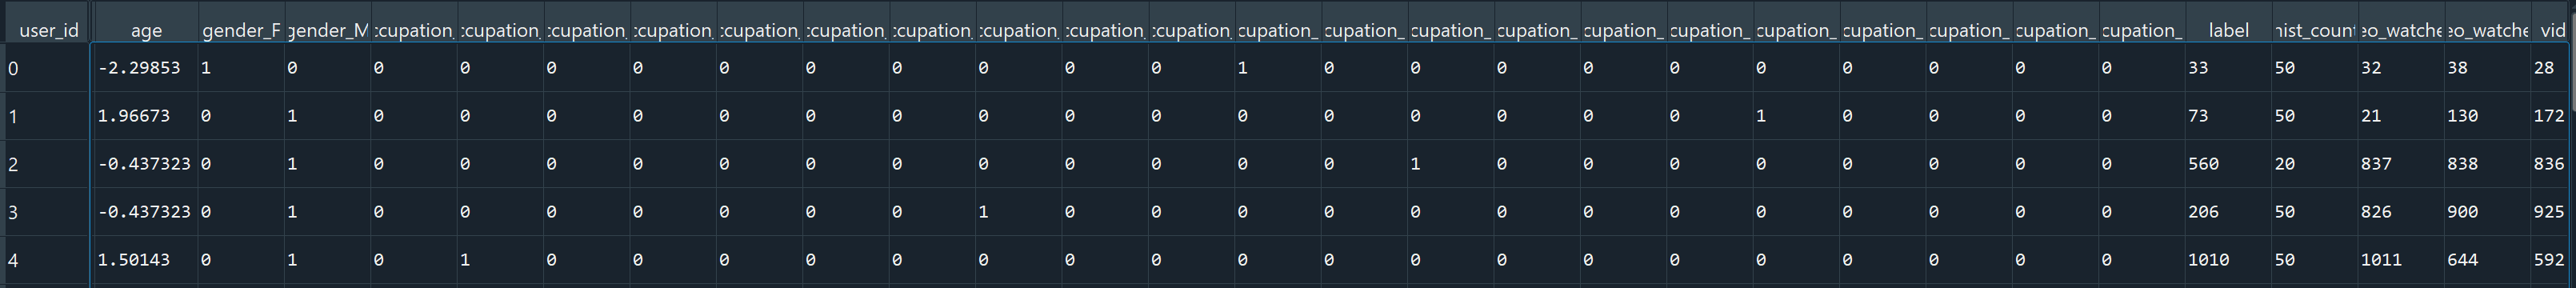

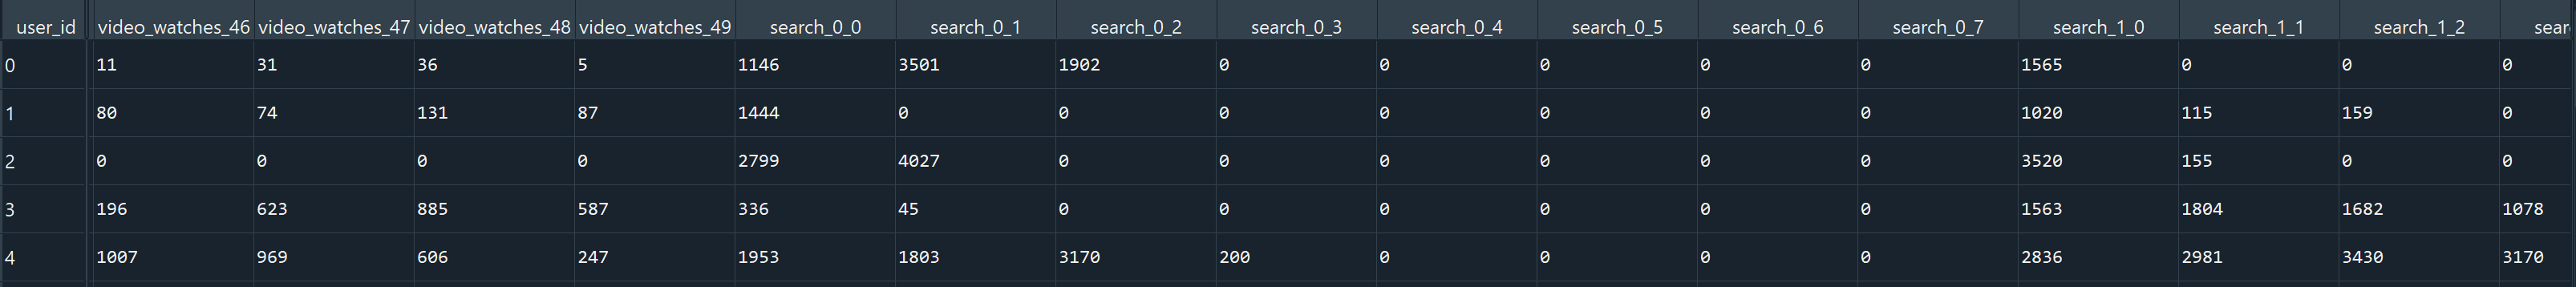

The training set has 6,040 rows and 478 columns (What? We have so many input features for the NN? The answer is NO, we will reduce it through embedding later). They are:


> User_id

> Age 

> Gender

> Occupation

> Video watches

> Search tokens

> Number of video watches

> Number of tokens

> Label

"Age", "gender", "occupation", "video watches", "search tokens" are useful input features of the neural network. The "number of video watches" and "number of tokens" are helper information for the neural network. 

The test set has two columns: user_id and label. The validation set is also the same.

In [42]:
print(test.head(2))

         user_id  label
user_id                
0              0     26
1              1    134


In [43]:
print(val.head(2))

         user_id  label
user_id                
0              0     35
1              1     67


## 2.3 Constructing embedding matrix.
Now I construct the embedding matrix, each row of which is the embedding values for a word in the vocabulary. In the neural network model building process, an word embedding layer with the same shape as the embedding matrix will be built, and its weights will be set to equal to the embedding matrix. There are 4,053 words in the vocabulary, 97 of which are not in GloVe. For words present in GloVe, I fill their Glove embedding values in the embedding matrix. For the words not present in GloVe, I assign a vector of small random numbers (from normal distribution of zero mean and *scale* variance, *scale* is a tuneable hyper-parameter) as its embedding values. At this stage, I also assign a vector of small random numbers to index 0 (but later on, I actually do not use this vector).

Please download the glove.6B.zip file [here](https://nlp.stanford.edu/data/glove.6B.zip) before running the code below.

In [45]:
def get_GloVe_dict(txt_file):
  '''
  Get a dictionary. The keys are the words and the values are the corresponding pre-trained embedding vectors.
  '''

  embeddings_dict = {}
  with open(txt_file, 'r', encoding="utf8") as f:
      for line in f:
          values = line.split()
          word = values[0]
          vector = np.asarray(values[1:], "float32")
          embeddings_dict[word] = vector
          
  return embeddings_dict


def get_embedding_dct(index_to_word, pretrained_emb_dct, scale = .01):
  '''Get embedding dictionary. 
  The keys are index in the vocabulary and the values are pre-trained embedding values.
  If the keys are not present in the pretrained_emb_dct, random values of normal distribution(0, scale) are filled as embedding values.
  
  Arguments:
  -- index_to_word: a dictionary, e.g. {0: 'the', 1: 'multiple'}.
  -- pretrained_emb_dct: a dictionary of pre-trained word embeddings, e.g. {'the': (1D numpy array)}.
  -- scale: the scale of normal distribution.
  
  Output:
  -- emb_dct: a dictionary. 
              The keys are the indices of index_to_word and the values are the corresponding pre-trained 
              word embeddings, e.g. {0: (1D numpy array)}
  '''
  emb_dct = {}
  word_emb_dim = len(pretrained_emb_dct['the'])
  for index, word in index_to_word.items():
      emb_dct[index] = pretrained_emb_dct.get(word, np.random.normal(scale=scale, size=word_emb_dim))
      
  return emb_dct


def get_emb_matrix(emb_dct):
  '''
  Get embedding matrix for the words in the vocabulary. 
  The shape of the embedding matrix is (vocabulary size, embedding dimensions).

  Parameters
  ----------
  emb_dct : Dictionary.
      The keys are the indices of index_to_word and the values are the corresponding pre-trained word embeddings, e.g. {0: (1D numpy array)}

  Returns
  -------
  emb_matrix : Numpy matrix shaped (vocabulary size, embedding dimensions).
      Each row is the pre-trained word embedding values for a word in the vocabulary.

  '''
  voc_size = len(emb_dct)
  word_emb_dim = len(emb_dct[0])
  emb_matrix = np.zeros((voc_size, word_emb_dim))
  i = 0
  while i < voc_size:
      emb_matrix[i,:] = emb_dct[i]
      i += 1
      
  return emb_matrix

GloVe_dct = get_GloVe_dict("glove.6B.50d.txt")   

# construct embedding dictionary. 
emb_dct = get_embedding_dct(index_to_word, GloVe_dct, scale = .01)

# get embedding matrix, which will be used as the word embedding layer in the neural network. 
emb_matrix = get_emb_matrix(emb_dct)

print(emb_matrix.shape)

(4054, 50)


# 2. Model building.

In [46]:
# CUDA and DataLoader
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [47]:
class TrainDataset(Dataset):

    def __init__(self, data):
        """
        Args:
            data: the dataset, in pandas DataFrame form.
        """
        self.df = data

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        ''' Retrieve instance(s) from data.
        
        Argument:
            -- idx: an integer of a list of integers.
            
        return: 
            -- A tuple storing (X,y), where X is a tensor shape (2,) and y is an integer.
        '''

        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        video_watches = self.df.filter(regex = 'video_watches')
        video_watches = video_watches.iloc[idx, :]
        video_watches = torch.tensor(video_watches.values, dtype = torch.long)
        
        search_tokens = self.df.filter(regex = 'search')
        search_tokens = search_tokens.iloc[idx, :]
        search_tokens = torch.tensor(search_tokens.values, dtype = torch.long)
        
        context = self.df.iloc[idx, 1:25]
        context = torch.tensor(context.values)
        
        hist_count = self.df.iloc[idx, self.df.columns == 'hist_count']
        hist_count = torch.tensor(hist_count.values, dtype = torch.long)
        
        token_count = self.df.iloc[idx, self.df.columns == 'token_count']
        token_count = torch.tensor(token_count.values, dtype = torch.long)
        
        y = self.df.iloc[idx, self.df.columns == 'label']
        y = torch.tensor(y.values, dtype = torch.long)
        
        X = (video_watches, search_tokens, context, hist_count, token_count)
        sample = (X, y)
        
        return sample

train_set = TrainDataset(train)    
loader_train = DataLoader(train_set, batch_size=32, shuffle = True, num_workers = 0)  

In [48]:
def create_emb_layer(emb_matrix, word_emb_non_trainable = True):
    ''' 
    Create an embedding layer for the NN.
    
    Arguments:
    -- emb_matrix: A matrix shaped (voc_size, embedding_dim) storing the pre-trained word embeddings.
    -- word_emb_non_trainable: True or False. If True, do not train the pre-trained word embeddings.
    
    Returns:
    -- token_emb: Embedding layer used in NN.
    -- voc_size: Vocabulary size.
    -- embedding_dim: Number of embedding dimensions.
    '''
    
    voc_size, embedding_dim = emb_matrix.shape
    token_emb = nn.Embedding(voc_size, embedding_dim, padding_idx = 0)
    token_emb.weight.data.copy_(torch.from_numpy(emb_matrix))
    
    if word_emb_non_trainable:
        token_emb.weight.requires_grad = False

    return token_emb


def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)

In [49]:
class CandidateGenerator(nn.Module):
    def __init__(self, num_of_movie, movie_emb_dim, emb_matrix, word_emb_non_trainable,
                 hidden_size1, hidden_size2, hidden_size3):
        super().__init__()
        word_emb_dim = emb_matrix.shape[1]
        self.movie_emb = nn.Embedding(num_of_movie, movie_emb_dim, padding_idx = 0) 
        self.token_emb = create_emb_layer(emb_matrix, word_emb_non_trainable)    # size (voc_size, embedding_dim)
        
        self.comb = nn.Sequential(
                        nn.Linear(movie_emb_dim+word_emb_dim+24, hidden_size1), 
                        nn.BatchNorm1d(hidden_size1),                      
                        nn.ReLU(inplace = True),
                        #nn.Dropout(p = 0.5),
                        
                        nn.Linear(hidden_size1, hidden_size2), 
                        nn.BatchNorm1d(hidden_size2),                      
                        nn.ReLU(inplace = True),
                        #nn.Dropout(p = 0.5),
                        
                        nn.Linear(hidden_size2, hidden_size3), 
                        nn.BatchNorm1d(hidden_size3),                      
                        nn.ReLU(inplace = True),
                        #nn.Dropout(p = 0.5),
                        
                        nn.Linear(hidden_size3, movie_emb_dim)
                    )
        
        self.comb.apply(init_weights)

    def forward(self, X):       
        video_watches, search_tokens, context, hist_count, token_count = X
        watches = self.movie_emb(video_watches)      # video_watches size: torch.Size([batch_size, max_his_count]). 
                                                     # watches size: ([batch_size, max_his_count, movie_emb_dime])
        watches = torch.sum(watches,1) / hist_count   # watches size: ([batch_size, movie_emb_dim])
        
        tokens = self.token_emb(search_tokens)       # search_tokens size: (batch_size, max_hist_len*max_token_len)
                                                     # tokens.size      ([batch_size, max_hist_len*max_token_len, word_emb_dim])
        tokens = torch.sum(tokens,1) / token_count   # tokens.size      ([batch_size, word_emb_dim])
        
        output = torch.cat((watches, tokens, context), 1)    # torch.Size([batch_size, 90])
        output = self.comb(output.float())
        
        return output

In [50]:
num_of_movie = len(movieID_to_index) + 1    # 1 is for padding

# tuneable hyper-parameters
movie_emb_dim = 16   
hidden_size1 = 256
hidden_size2 = 64
hidden_size3 = 32
max_epoch = 2

model = CandidateGenerator(num_of_movie, movie_emb_dim, emb_matrix, word_emb_non_trainable=True,
                 hidden_size1=hidden_size1, hidden_size2=hidden_size2, hidden_size3=hidden_size3)

Linear(in_features=90, out_features=256, bias=True)
BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Linear(in_features=256, out_features=64, bias=True)
BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Linear(in_features=64, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Linear(in_features=32, out_features=16, bias=True)
Sequential(
  (0): Linear(in_features=90, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=256, out_features=64, bias=True)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=